## Computing transport in a section

In [16]:
import numpy as np
import xarray as xr
#import xorca_brokenline as bl
#import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
from matplotlib import colors as c
from matplotlib import pyplot as plt
from pathlib import Path
#import seawater
%matplotlib inline

In [17]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})

global_data_path = Path("./GeomarData")
experiment_id = "INALT20.L46-KFS044"
nest_prefix = "1_"  # leave empty if global data will be used
code_area = "_9W_35S10S"
time_average = "5d"

In [18]:
# chunk sizes
chu_x = 21
chu_y = 551
chu_z = 46
chu_t = 1

## Start Dask client

We want to be able to control the resources used for parallel computations.

In [19]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, memory_limit=8e9)
client

/usr/local/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:53066 Dashboard: http://127.0.0.1:53067/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


## Data files

In [120]:
MESH_MASK_files = list(sorted(
    (global_data_path / "mask" / experiment_id).glob(
        f"{nest_prefix}mesh_mask{code_area}.nc"
    )
))

U_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_{time_average}_200*_*_grid_U{code_area}.nc"
    )
))

V_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_{time_average}_200*_*_grid_V{code_area}.nc"
    )
))

print(f"Found {len(MESH_MASK_files)} mesh/mask files, {len(U_files)} U files, and {len(V_files)} V files.")

Found 1 mesh/mask files, 0 U files, and 0 V files.


In [21]:
MESH_MASK_files

[PosixPath('GeomarData/mask/INALT20.L46-KFS044/1_mesh_mask_9W_35S10S.nc')]

## Load Data

In [22]:
#Auxiliary data
ds_mesh_mask = xr.open_mfdataset(
    MESH_MASK_files,
    chunks={
        "z": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')
#ds_mesh_mask = ds_mesh_mask.squeeze()  # remove degenerate time dim
#ds_mesh_mask = ds_mesh_mask.set_coords(["nav_lat", "nav_lon"])
#neccesary for xorca_brokenline to work
#ds_mesh_mask = ds_mesh_mask.expand_dims('t')
#ds_mesh_mask = ds_mesh_mask.rename({'nav_lev':'nav_lev_0'})
#ds_mesh_mask['nav_lev'] = ds_mesh_mask.nav_lev_0.isel(t=0)
ds_mesh_mask = ds_mesh_mask.rename({'e3t_0':'e3t','e3u_0':'e3u','e3v_0':'e3v'})

ds_mesh_mask

<xarray.Dataset>
Dimensions:       (t: 1, x: 21, y: 551, z: 46)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 551, 21), meta=np.ndarray>
    e3t           (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    e3u           (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    e3v           (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    gdepw_1d      (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    e3w_1d        (t, z) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
Attributes:
    hist

In [36]:
ds_U = xr.open_mfdataset(
    U_files,
    chunks={
        "time_counter": chu_t,
        "depthu": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')

In [37]:
ds_U = ds_U.rename({"time_counter" : "t", "depthu" : "z"})
ds_U

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, t: 730, x: 21, y: 551, z: 46)
Coordinates:
    nav_lon               (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lat               (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
  * z                     (z) float32 3.0467727 9.454049 ... 5624.9517 5875.141
    time_centered         (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t                     (t) object 2000-01-03 12:00:00 ... 2009-12-29 12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (t, z, axis_nbounds) float32 dask.array<chunksize=(73, 46, 2), meta=np.ndarray>
    time_centered_bounds  (t, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (t, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    vozocrtx              (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
Attributes:
    name:                      1_INALT20.L46-KFS044_5d_20000101_20001231
    description:               ocean U grid variables
    title:                     ocean U grid variables
    Conventions:               CF-1.5
    production:                An IPSL model
    timeStamp:                 2017-Jan-15 09:25:17 CET
    history:                   Mon Jun 24 08:55:57 2019: ncrcat -F -d x,1200,...
    NCO:                       4.6.8
    nco_openmp_thread_number:  1

In [40]:
U = ds_U.vozocrtx
U

<xarray.DataArray 'vozocrtx' (t: 730, z: 46, y: 551, x: 21)>
dask.array<concatenate, shape=(730, 46, 551, 21), dtype=float32, chunksize=(1, 46, 551, 21), chunktype=numpy.ndarray>
Coordinates:
    nav_lon        (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
  * z              (z) float32 3.0467727 9.454049 ... 5624.9517 5875.141
    time_centered  (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t              (t) object 2000-01-03 12:00:00 ... 2009-12-29 12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_x_velocity
    long_name:           ocean current along i-axis
    units:               m/s
    online_operation:    average
    interval_operation:  400 s
    interval_write:      5 d
    cell_methods:        time: mean (interval: 400 s)

In [45]:
ds_V = xr.open_mfdataset(
    V_files,
    chunks={
        "time_counter": chu_t,
        "depthv": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')

In [48]:
ds_V = ds_V.rename({"time_counter" : "t", "depthv" : "z"})
ds_V

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, t: 730, x: 21, y: 551, z: 46)
Coordinates:
    nav_lon               (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lat               (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
  * z                     (z) float32 3.0467727 9.454049 ... 5624.9517 5875.141
    time_centered         (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t                     (t) object 2000-01-03 12:00:00 ... 2009-12-29 12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthv_bounds         (t, z, axis_nbounds) float32 dask.array<chunksize=(73, 46, 2), meta=np.ndarray>
    time_centered_bounds  (t, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (t, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    vomecrty              (t, z, y, x) float32 dask.array<chunksize=(1, 46, 551, 21), meta=np.ndarray>
Attributes:
    name:                      1_INALT20.L46-KFS044_5d_20000101_20001231
    description:               ocean V grid variables
    title:                     ocean V grid variables
    Conventions:               CF-1.5
    production:                An IPSL model
    timeStamp:                 2017-Jan-15 09:25:17 CET
    history:                   Mon Jun 24 08:57:08 2019: ncrcat -F -d x,1200,...
    NCO:                       4.6.8
    nco_openmp_thread_number:  1

In [50]:
V = ds_V.vomecrty

In [51]:
V

<xarray.DataArray 'vomecrty' (t: 730, z: 46, y: 551, x: 21)>
dask.array<concatenate, shape=(730, 46, 551, 21), dtype=float32, chunksize=(1, 46, 551, 21), chunktype=numpy.ndarray>
Coordinates:
    nav_lon        (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(551, 21), meta=np.ndarray>
  * z              (z) float32 3.0467727 9.454049 ... 5624.9517 5875.141
    time_centered  (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t              (t) object 2000-01-03 12:00:00 ... 2009-12-29 12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_y_velocity
    long_name:           ocean current along j-axis
    units:               m/s
    online_operation:    average
    interval_operation:  400 s
    interval_write:      5 d
    cell_methods:        time: mean (interval: 400 s)

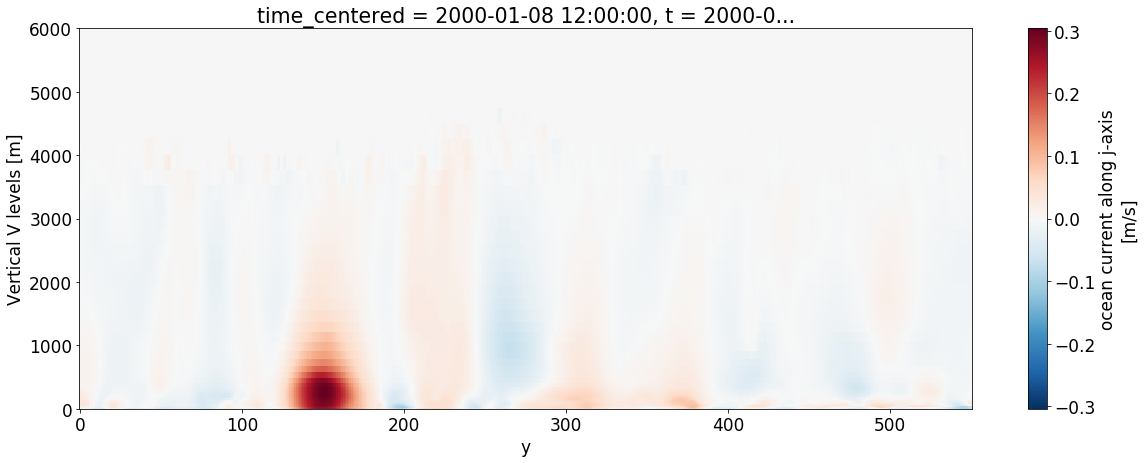

In [52]:
V.isel(t=1).isel(x=11).plot()

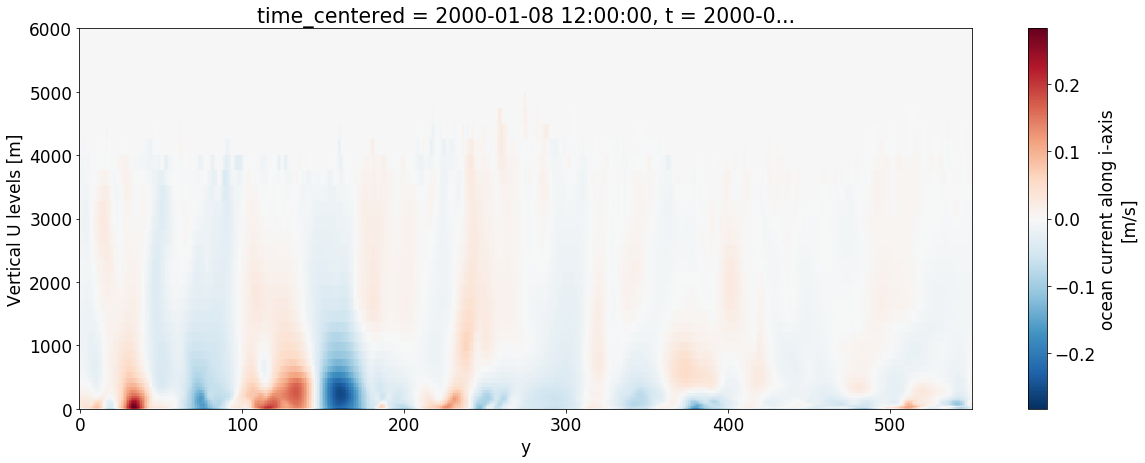

In [53]:
U.isel(t=1).isel(x=11).plot()

## Define section

In [58]:
prev=U.z.values

In [63]:
pre_min = 1000;
pre_max = 3000;
prev=U.z.values
ipre_min = (np.abs(prev-pre_min)).argmin()
ipre_max = (np.abs(prev-pre_max)).argmin()

33

In [103]:
lon_sa_min=-9
lon_sa_max=-9
lat_sa_min=-32
lat_sa_max=-20

lonv = U.nav_lon.isel(y=0).values
ilonv_min = (np.abs(lonv-lon_sa_min)).argmin()
ilonv_max = (np.abs(lonv-lon_sa_max)).argmin()

latv = U.nav_lat.isel(x=0).values
ilatv_min = (np.abs(latv-lat_sa_min)).argmin()
ilatv_max = (np.abs(latv-lat_sa_max)).argmin()

print('ilon:',ilonv_min,ilonv_max)
print('ilat:',ilatv_min,ilatv_max)

ilon: 9 9
ilat: 74 342


In [104]:
ji_pairs = [
    (ilatv_min, ilonv_min),
    (ilatv_max,ilonv_max)
]

In [105]:
fmask = ds_mesh_mask['fmask'].isel(z=0,t=0)

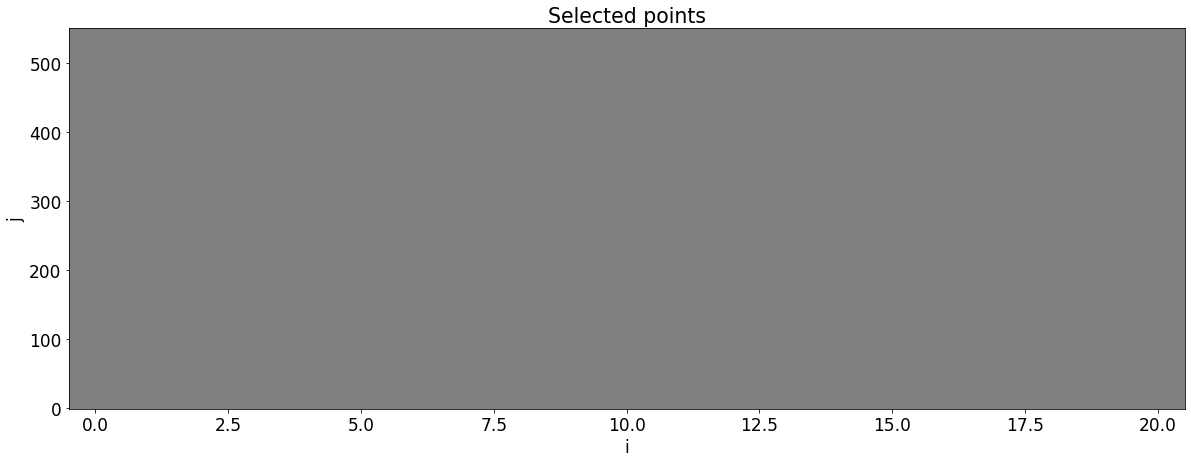

In [106]:
fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
#plt.plot(ii,jj,'x')

plt.ylabel("j")
plt.xlabel("i")
plt.title('Selected points');

## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.


In [107]:
U_saga=U.isel(x=ilonv_min,y=slice(ilatv_min,ilatv_max),z=slice(ipre_min,ipre_max))

In [108]:
e3u_saga=ds_mesh_mask.e3u.isel(x=ilonv_min,y=slice(ilatv_min,ilatv_max),z=slice(ipre_min,ipre_max),t=0)
e2u_saga=ds_mesh_mask.e2u.isel(x=ilonv_min,y=slice(ilatv_min,ilatv_max),t=0)

In [109]:
e3u_saga

<xarray.DataArray 'e3u' (z: 10, y: 268)>
dask.array<getitem, shape=(10, 268), dtype=float64, chunksize=(10, 268), chunktype=numpy.ndarray>
Dimensions without coordinates: z, y

In [110]:
U_saga

<xarray.DataArray 'vozocrtx' (t: 730, z: 10, y: 268)>
dask.array<getitem, shape=(730, 10, 268), dtype=float32, chunksize=(1, 10, 268), chunktype=numpy.ndarray>
Coordinates:
    nav_lon        (y) float32 dask.array<chunksize=(268,), meta=np.ndarray>
    nav_lat        (y) float32 dask.array<chunksize=(268,), meta=np.ndarray>
  * z              (z) float32 989.2289 1136.922 ... 2485.3708 2710.1333
    time_centered  (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t              (t) object 2000-01-03 12:00:00 ... 2009-12-29 12:00:00
Dimensions without coordinates: y
Attributes:
    standard_name:       sea_water_x_velocity
    long_name:           ocean current along i-axis
    units:               m/s
    online_operation:    average
    interval_operation:  400 s
    interval_write:      5 d
    cell_methods:        time: mean (interval: 400 s)

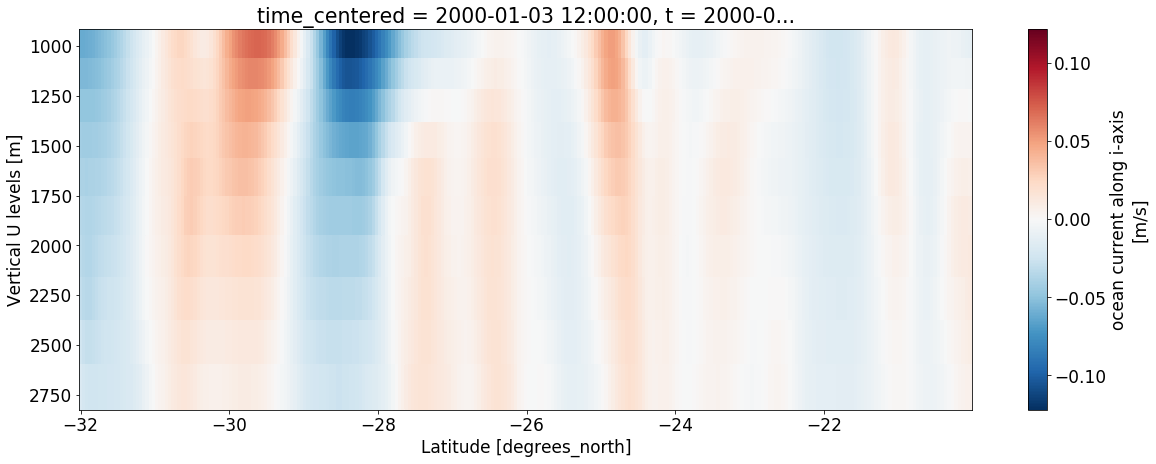

In [111]:
U_saga.isel(t=0).plot(x="nav_lat",y="z",yincrease=False);

In [112]:
e2u_saga

<xarray.DataArray 'e2u' (y: 268)>
dask.array<getitem, shape=(268,), dtype=float64, chunksize=(268,), chunktype=numpy.ndarray>
Dimensions without coordinates: y

In [113]:
accU = (U_saga*e3u_saga*e2u_saga).sum("z").cumsum("y")/ 1.0e6

In [114]:
accU = accU.rename('AccumulatedTransportU')

In [115]:
accUme = accU.mean(dim="t")
accUst = accU.std(dim="t")

In [116]:
accUme = accUme.compute()

In [117]:
accUst = accUst.compute()

<xarray.DataArray 'AccumulatedTransportU' (t: 730, y: 268)>
dask.array<truediv, shape=(730, 268), dtype=float64, chunksize=(1, 268), chunktype=numpy.ndarray>
Coordinates:
    nav_lon        (y) float32 dask.array<chunksize=(268,), meta=np.ndarray>
    nav_lat        (y) float32 dask.array<chunksize=(268,), meta=np.ndarray>
    time_centered  (t) object dask.array<chunksize=(1,), meta=np.ndarray>
  * t              (t) object 2000-01-03 12:00:00 ... 2009-12-29 12:00:00
Dimensions without coordinates: y

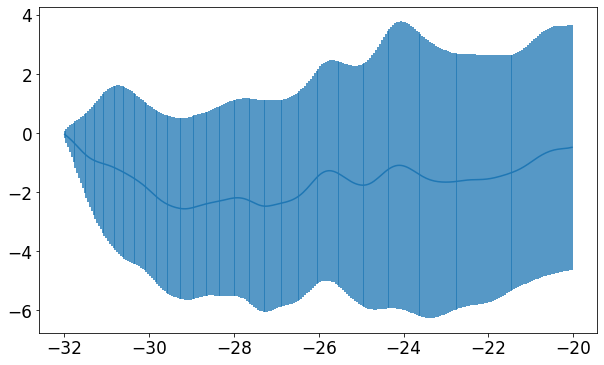

In [119]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x=accUme.nav_lat,y=accUme,yerr=accUst)
#ax.plot(accUme.nav_lat,accUme)
accU